# K-Means Clustering

In this notebook, I will cover an implementation of the K-Means clustering algorithm. Results will be compared with those obtained from scikit-learn's K-Means model.

In [1]:
# imports
import numpy as np
from typing import Tuple, Dict
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score

In [2]:
class KMeans(object):
    """
    Class to encapsulate the K-Means algorithm
    """
    
    def __init__(self, K: int=3, n_init: int=10, max_iters: int=100) -> None:
        """
        Initialiser function for a class instance
        
        Inputs:
            K            -> integer number of clusters to assign
            n_init       -> integer number of times the algorithm will be applied when training
            max_iters    -> maximum number of iterations the algorithm is allowed to run before stopping
        """
        if K <= 0:
            raise ValueError(f'K must be a positive integer, got: {K}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')    
        self.K          = K
        self.n_init     = n_init
        self.centroids  = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters  = max_iters
        
    def __del__(self) -> None:
        """
        Destructor function for class instance
        """
        del self.K
        del self.n_init
        del self.centroids
        del self.total_wcss
        del self.wcss_array
        del self.max_iters
        
    def __assign_samples(self, X : np.array, centroids : np.array) -> np.array:
        """
        Private function to assign samples to clusters
        
        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
            numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        # compute difference between input features & centroids through broadcasting
        differences = X[:,np.newaxis] - centroids[np.newaxis]
        # compute the squared euclidean distance for every (number_samples, K) pairs
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        # find minimal distance for each sample & return
        return np.argmin(euclid_dist, axis=1)
      
    def __partition_data(self, X : np.array, cluster_assignment : np.array) -> list:
        """
        Private function to partition input features according to cluster assignment
        
        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluser assignments with shape: [number_samples,]
        Output:
            list of numpy arrays of centroid for cluster, each array with shape: 
            [cluster_number_samples, number_features]
        """
        # join features and cluster assignment
        X_assigned = np.concatenate((X, cluster_assignment.reshape(-1,1)),axis=1)
        # sort on the cluster assignment
        X_assigned = X_assigned[X_assigned[:, -1].argsort()]
        # partition the data based on the cluster assignment & return
        return np.split(X_assigned[:,:-1], np.unique(X_assigned[:, -1], return_index=True)[1][1:])
        
    def __compute_wcss(self, X : np.array, cluster_assignment : np.array, 
                       centroids : np.array) -> Tuple[float, np.array]:
        """
        Private function to compute WCSS over all clusters
        
        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluser assignments with shape: [number_samples,]
            centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
            tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute the WCSS for each cluster
        wcss_array = np.array([np.einsum('ij,ij', X_clusters[i] - centroids[i,:], 
                                         X_clusters[i] - centroids[i,:]) for i in range(self.K)])
        # return the WCSS per cluster, along with the sum over all clusters
        return (np.sum(wcss_array), wcss_array)
        
    def __update_centroids(self, X : np.array, cluster_assignment : np.array) -> np.array:
        """
        Private function to update cluster centroids
        
        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluser assignments with shape: [number_samples,]
        Output:
            numpy array of centroids with shape: [K, number_features]
        """         
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute new centroids & return
        return np.array([np.mean(x, axis=0) for x in X_clusters])
     
    def fit(self, X : np.array) -> None:
        """
        Training function for the class. Aims to find the optimal centroid values that minimise the WCSS 
        
        Inputs:
            X -> numpy array of input features of assumed  shape [number_samples, number_features]
        """
        # initialise wcss score
        self.total_wcss = np.inf
        
        # loop over all iterations requested
        for _ in range(self.n_init):
            
            # initialise centroids
            centroids     = X[np.random.choice(X.shape[0], self.K, replace=False)]
            old_centroids = np.copy(centroids)
            # loop through the K-Means learning algorithm
            centroid_diff = np.ones((self.K))
            iteration     = 0
            while (not np.array_equal(centroid_diff,np.zeros(self.K))) and iteration < self.max_iters:
                # assign samples to clusters
                cluster_assignment = self.__assign_samples(X, centroids)
                # update centroids
                centroids = self.__update_centroids(X, cluster_assignment)
                # compute difference between centroids
                centroid_diff = np.abs(old_centroids - centroids)
                # increment counter & reset old_centroids
                iteration    += 1
                old_centroids = np.copy(centroids)
                
            # compute WCSS for the resulting clusters
            total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)
            # check if we have a new optimal centroid configuration?
            if total_wcss < self.total_wcss:
                # if so, update storage objects
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.centroids  = centroids
            
    def predict(self, X : np.array) -> None:
        """
        Predict function for the class. Assigns cluster labels to each sample based on proximity to centroids
        
        Input:
            X -> numpy array of input features of assumed shape [number_samples, number_features]
        Output:
            numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)
    
    def return_wcss(self) -> Tuple[float, np.array]:
        """
        Public function to return WCSS scores (after training)
        
        Output:
            tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)
    
    def return_centroids(self) -> np.array:
        """
        Public function to return centroids (after training)
        
        Output:
            numpy array containing the centroids with shape: [K, number_features]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids    
    
    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
            deep -> boolean input parameter
        Outputs:
            Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K,
                'n_init':self.n_init,
                'max_iters':self.max_iters}

## Create Dataset

I will make use of *make_blobs* from scikit-learn to produce a synthetic dataset. Let's go ahead and produce these data & visualise.

In [3]:
# produce dataset
X, y, centers = make_blobs(n_samples=1000, centers=3, n_features=2, return_centers=True, random_state=0)

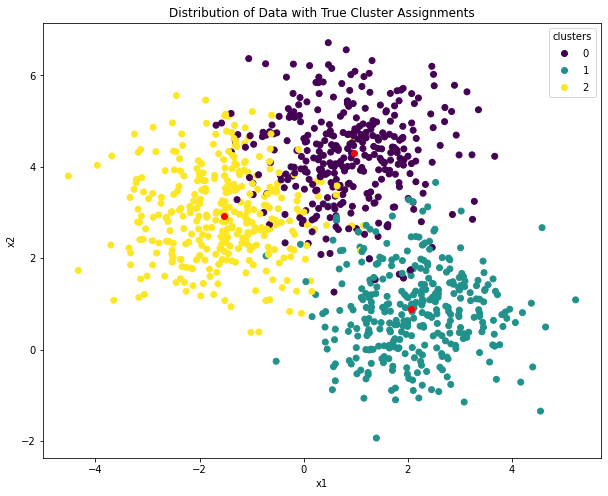

In [4]:
# visualise data
fig, ax    = plt.subplots(figsize=(10,8))
sc         = ax.scatter(X[:,0],X[:,1],c=y)
sc_centers = ax.scatter(centers[:,0],centers[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with True Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

## Apply our Custom K-Means to these Data

Let's now attempt to find the clusters in the data, by making use of our custom K-Means implementation.

In [5]:
# create an instance of KMeans
clt = KMeans(max_iters=300)

In [6]:
# fit the model to the data
clt.fit(X)

In [7]:
# obtain predictions
y_pred = clt.predict(X)

In [8]:
# obtain predicted centroids
centers_pred = clt.return_centroids()

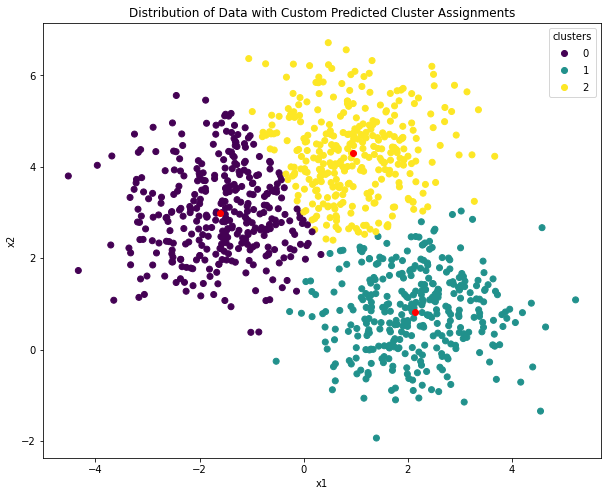

In [9]:
# visualise predictions
fig, ax    = plt.subplots(figsize=(10,8))
sc         = ax.scatter(X[:,0],X[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Custom Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [10]:
# return cluster errors
clt.return_wcss()

(1685.7317234035838, array([589.61466741, 566.13539606, 529.98165993]))

In [14]:
# how accurate are our estimated centroids?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[2,1,0]]):.4f}')

The mean absolute error between the predicted and true centroids is: 0.0572


In [15]:
# calibrate labelling (if needed)
idx_0         = y_pred == 0
idx_1         = y_pred == 1
idx_2         = y_pred == 2
y_pred[idx_0] = 2
y_pred[idx_1] = 1
y_pred[idx_2] = 0

In [16]:
# how accurate are our cluster assignments?
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1  = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 0.9180
Precision score: 0.9179
Recall score: 0.9180
F1 score: 0.9179


These results look good: the mean difference between centroids is small, and the accuracy, precision, recall, and F1 scores are reasonably high. We should not expect these metrics to be 100%, since there is overlap between the clusters (as indicated by the true cluster assignments plot). This overlap cannot be distinguished by K-Means.

## Scikit-learn K-Means Implementation

Now let's compare the results above with those we can obtain with the scikit-learn implementation of K-Means. We can start by importing the model, training it, and then generating predictions:

In [17]:
# import scikit-learn K-Means
from sklearn.cluster import KMeans

In [18]:
# create an instance of KMeans
clt = KMeans(n_clusters=3, max_iter=300, random_state=0)

In [19]:
# fit the model to the data
clt.fit(X)

KMeans(n_clusters=3, random_state=0)

In [20]:
# obtain predictions
y_pred = clt.predict(X)

In [21]:
# obtain predicted centroids
centers_pred = clt.cluster_centers_

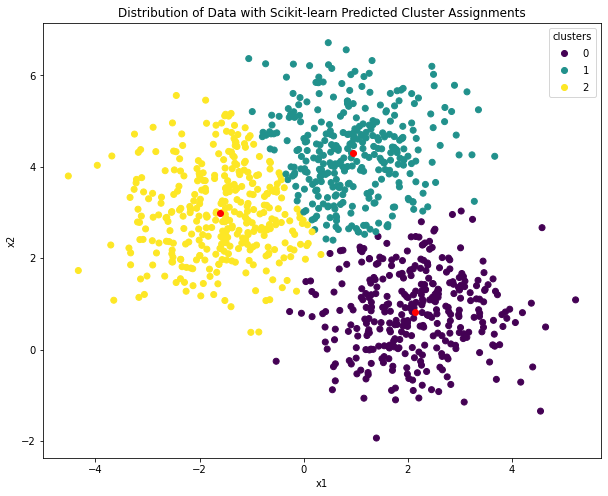

In [22]:
# visualise predictions
fig, ax    = plt.subplots(figsize=(10,8))
sc         = ax.scatter(X[:,0],X[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Scikit-learn Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [26]:
# how accurate are our estimated centroids?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[1,0,2]]):.4f}')

The mean absolute error between the predicted and true centroids is: 0.0572


In [27]:
# calibrate labelling (if needed)
idx_0         = y_pred == 0
idx_1         = y_pred == 1
idx_2         = y_pred == 2
y_pred[idx_0] = 1
y_pred[idx_1] = 0
y_pred[idx_2] = 2

In [28]:
# how accurate are our cluster assignments?
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1  = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 0.9180
Precision score: 0.9179
Recall score: 0.9180
F1 score: 0.9179


These results are identical to those we obtained with our custom implementation, indicating that we've done a good job on our custom K-Means model.